In [1]:
import numpy as np
import scipy
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

c:\Users\camil\Desktop\TP5-main\myenv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


19/01/01 photo

# Manipulate the device and the precision

**Question**

In PyTorch, each tensor has a `device` and a `dtype`. The `device` refers to the device on which the tensor is currently loaded. The `dtype` is the type of data stored in the tensor. By default, `device = torch.device("cpu")` and `dtype = torch.float32`.

One can build a tensor directly on a given device and with a given data type (or precision) by using the optional arguments `device` and `dtype`, or we can build them first with by-default values, and send copy them on the desired device with the desired precision with the `to` method.

Use both methods with devices `torch.device("cuda")` and `torch.device("cpu")` and with data types other than `torch.float32`.

In [2]:
with_cuda = torch.cuda.is_available()
if with_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
dtype = torch.float64

# Backpropagation of the gradient

## Introduction

Code libraries such as PyTorch, TensorFlow, JAX implement **automatic differentation (AutoDiff)** methods, which are at the core of ML methods trainable by gradient-based optimization techniques. These ML method include naturally neural networks.

AutoDiff is based on the construction of a computational graph, which is a *Directed Acyclic Graph* (DAG). This graph represents the different stages of computation of a function $f$ at a point $\boldsymbol{\theta} = (\theta_1, \theta_2, \cdots, \theta_S)$, and we want to compute:
$$
\frac{\partial f}{\partial \theta_1}, \frac{\partial f}{\partial \theta_2}, \cdots,
\frac{\partial f}{\partial \theta_S} .
$$
The DAG is then made of:
 * *directed* edges: represent the flows of data;
 * the root of the graph (a node which does not has any child): contains the (scalar) result of the computation of $f(\boldsymbol{\theta})$;
 * the leaf nodes (nodes which do not have any parent): contain the variables $(\theta_1, \theta_2, \cdots, \theta_S)$ with repect to which we want to differentiate $f$;
 * the non-leaf nodes: contain an operation to perform on their inputs.

In PyTorch, the leaf nodes are built either automatically when initializing a `torch.nn.Module` (such as a linear layer, in which weights and biases are by-default leaf nodes), or manually trough the class `torch.nn.Parameter`. Tensors that we use during a computation, but that are not variables of our function are just instances of the class `torch.Tensor` (with `requires_grad = False`).

The DAG is built on-the-fly during the successive operations, and the gradients are computed only when calling the `backward` method on the root node, or the function `torch.autograd.grad` on the root node and the leaf nodes with respect to which we want to differentiate. Using `backward` is very straightforward, while `torch.autograd.grad` is slightly more complex, but it supports advanced custom operations.

## Parameters and tensors

**Question 1**

Build some `torch.nn.Parameter`, some `torch.Tensor` and some `torch.Tensor` with `requires_grad = True`.

Note: The main difference between a `Parameter` and a `Tensor` with `requires_grad = True` is how they are managed inside a PyTorch `Module`. To avoid any unexpected behavior, one should prefer to use `Parameter`.

## Computing gradients

**Question 2**

Let $f$ be the function defined below. Compute its derivative with respect to `x1` and `x2` by using `backward`, and then by using `torch.autograd.grad`.

### backward

In [4]:
x1 = nn.Parameter(torch.randn(5)) #tensors gaussiens vecteur de taille 5-> parameter va permettre de calculer le gradient après
x2 = nn.Parameter(torch.randn(1).squeeze()) # transforme vecteur taille 1 à un scalaire (vecteur taille 0)
a = torch.randn(5) # crée tensors et pas paramètres
b = torch.randn(1).squeeze()
c = torch.randn(3, 4, requires_grad=False)
y = x2 * torch.sin((a * x1).sum() + b)

In [5]:
print(x1.grad, x2.grad)
y.backward()
print(x1.grad, x2.grad)

None None
tensor([ 0.0019,  0.0256, -0.0152, -0.0020,  0.0008]) tensor(0.9199)


### torch.autograd.grad

In [6]:
x1 = nn.Parameter(torch.randn(5)) #tensors gaussiens vecteur de taille 5-> parameter va permettre de calculer le gradient après
x2 = nn.Parameter(torch.randn(1).squeeze()) # transforme vecteur taille 1 à un scalaire (vecteur taille 0)
a = torch.randn(5) # crée tensors et pas paramètres
b = torch.randn(1).squeeze()
c = torch.randn(3, 4, requires_grad=False)
y = x2 * torch.sin((a * x1).sum() + b)

grads = torch.autograd.grad(y, (x1, x2))
print(grads[0])
print(grads[1])

tensor([-1.3438,  0.5883,  0.0655, -0.8346,  0.2505])
tensor(-0.8426)


### Higher-order derivatives

**Question 3**

Compute $\frac{\partial f}{\partial x_1 \partial x_2}$ by using `torch.autograd.grad` twice. One check how to use the additional parameters `create_graph` and `allow_unused`.

In [7]:
x1 = nn.Parameter(torch.randn(5)) #tensors gaussiens vecteur de taille 5-> parameter va permettre de calculer le gradient après
x2 = nn.Parameter(torch.randn(1).squeeze()) # transforme vecteur taille 1 à un scalaire (vecteur taille 0)
a = torch.randn(5) # crée tensors et pas paramètres
b = torch.randn(1).squeeze()
c = torch.randn(3, 4, requires_grad=False)
y = x2 * torch.sin((a * x1).sum() + b)

grads_x1, grads_x2 = torch.autograd.grad(y, (x1,x2), create_graph = True)
print(grads_x1, grads_x2)
hessian_x2_x1 = torch.autograd.grad(grads_x2, (x1,), retain_graph=True, allow_unused = True)
print(hessian_x2_x1)

tensor([-0.1591,  0.0526, -0.1064,  0.0070,  0.0733], grad_fn=<MulBackward0>) tensor(0.7452, grad_fn=<MulBackward0>)
(tensor([-0.6691,  0.2213, -0.4475,  0.0293,  0.3082]),)


## Access the computational graph

**Question 4**

The root node contains all the required information to perform the backpropagation and compute the derivatives. The graph and the nodes can be accessed with the methods `grad_fn` and `next_functions`. The leaf nodes can be accessed with the `variable` method. Before the backward, the intermediady results can be accessed with `_saved_self`.

Access the various nodes of the graph.

In [8]:
x1 = nn.Parameter(torch.randn(5)) #tensors gaussiens vecteur de taille 5-> parameter va permettre de calculer le gradient après
x2 = nn.Parameter(torch.randn(1).squeeze()) # transforme vecteur taille 1 à un scalaire (vecteur taille 0)
a = torch.randn(5) # crée tensors et pas paramètres
b = torch.randn(1).squeeze()

y = x2 * torch.sin((a * x1).sum() + b)
y.backward()

print(y)
print(y.grad_fn)
print(y.grad_fn.next_functions)

tensor(-1.2236, grad_fn=<MulBackward0>)
((<AccumulateGrad object at 0x0000020F0B065810>, 0), (<SinBackward0 object at 0x0000020F0B066DA0>, 0))


In [9]:
# Other example

x = nn.Parameter(torch.randn(6))
y = torch.split(x, 2)
z = sum(y).sum()
z.backward()

print(z)
print(z.grad_fn)
print(z.grad_fn.next_functions)

tensor(-3.2625, grad_fn=<SumBackward0>)
((<AddBackward0 object at 0x0000020F0B067670>, 0),)


## Forward-only mode

**Question 5**

Sometimes, for instance when testing a model, we are just interested in the result, and not the gradients. Such computations are more efficient if we are in a "forward-only" mode (in that situation, the computational graph is not created and the intermediary results are not stored).

The easiest way is to use `with torch.no_grad()`. One can also use the method `detach` on the parameters to use their content without building the computational graph.

Compute the function $f$ without building the computational graph using both methods and check that no computational graph is stored.

In [10]:
# with torch.no_grad()
x1 = nn.Parameter(torch.randn(5)) #tensors gaussiens vecteur de taille 5-> parameter va permettre de calculer le gradient après
x2 = nn.Parameter(torch.randn(1).squeeze()) # transforme vecteur taille 1 à un scalaire (vecteur taille 0)
a = torch.randn(5) # crée tensors et pas paramètres
b = torch.randn(1).squeeze()
with torch.no_grad():
  y = x2 * torch.sin((a * x1).sum() + b)
print(y)

tensor(0.4602)


In [11]:
# detach() extrait contenu du résultat en oubliant tout sur le graph de calculs
x1 = nn.Parameter(torch.randn(5)) #tensors gaussiens vecteur de taille 5-> parameter va permettre de calculer le gradient après
x2 = nn.Parameter(torch.randn(1).squeeze()) # transforme vecteur taille 1 à un scalaire (vecteur taille 0)
a = torch.randn(5) # crée tensors et pas paramètres
b = torch.randn(1).squeeze()
y = x2 * torch.sin((a * x1).sum() + b)
with torch.no_grad():
  y = x2.detach()* torch.sin((a * x1.detach()).sum() + b)
print(y)


tensor(-0.0014)


# Managing a dataset

Before training a model on a dataset, we have to make some basic checks on the dataset and preprocess it correctly in order to obtain the best possible results (on a validation set).

In [12]:
datasets_path = "/home/ercede23/Documents/"

## Checking a sample

First, we load MNIST.

In [13]:
batch_size = 64

# build transform
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

# choose the training and test datasets
train_data = datasets.MNIST(datasets_path, train = True,
                              download = True, transform = transform)
test_data = datasets.MNIST(datasets_path, train=False,
                             download = True, transform = transform)

train_size = len(train_data)
test_size = len(test_data)

# build the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

# specify the image classes
classes = [f"{i}" for i in range(10)]

**Question 1**

By using `numpy.random.choice`, subplots and the function `imshow` of matplotlib, print 10 (or more) random data points of the training set (image + label).

Is the task feasible for a human? Do the data look clean ?

In [14]:
import matplotlib.pyplot as plt


In [15]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/ercede23/Documents/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


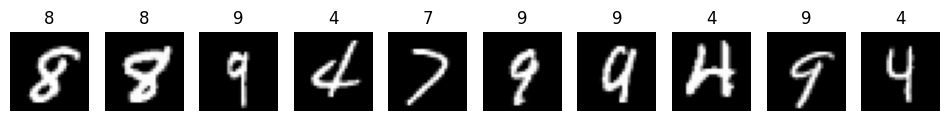

In [16]:
indices = np.random.choice(len(train_data), 10, replace=False)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))

for ax, idx in zip(axes, indices):
    img, label = train_data[idx]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(label)
    ax.axis("off")

plt.show()

## Check for class imbalance

**Question 2**

In classification tasks, it is common that the different classes are inequally represented in the dataset. If this "class imbalance" is too severe, the model is likely to fail to learn well the least represented classes.

Compute the number of data points in each class (in the training dataset). What do we observe?

In [17]:
counts = torch.zeros(10, dtype=torch.int)

for _, label in train_data:
  counts[label] += 1

for i in range(10):
  print('number of data points in ', i, 'is: ', counts[i])

number of data points in  0 is:  tensor(5923, dtype=torch.int32)
number of data points in  1 is:  tensor(6742, dtype=torch.int32)
number of data points in  2 is:  tensor(5958, dtype=torch.int32)
number of data points in  3 is:  tensor(6131, dtype=torch.int32)
number of data points in  4 is:  tensor(5842, dtype=torch.int32)
number of data points in  5 is:  tensor(5421, dtype=torch.int32)
number of data points in  6 is:  tensor(5918, dtype=torch.int32)
number of data points in  7 is:  tensor(6265, dtype=torch.int32)
number of data points in  8 is:  tensor(5851, dtype=torch.int32)
number of data points in  9 is:  tensor(5949, dtype=torch.int32)


Theoretical number of data points per class if the dataset was perfectly balanced: 6000.

# Managing a model

In [18]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.act_function = torch.tanh
        layers = [1, 6, 16, 120, 84, 10]

        self.conv1 = torch.nn.Conv2d(layers[0], layers[1], 5, padding = 2)
        self.conv2 = torch.nn.Conv2d(layers[1], layers[2], 5)
        self.fc1 = torch.nn.Linear(5 * 5 * layers[2], layers[3])
        self.fc2 = torch.nn.Linear(layers[3], layers[4])
        self.fc3 = torch.nn.Linear(layers[4], layers[5])


    def forward(self, x):
        x = self.conv1(x)
        x = self.act_function(x)
        x = torch.nn.functional.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.act_function(x)
        x = torch.nn.functional.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.act_function(x)

        x = self.fc2(x)
        x = self.act_function(x)

        x = self.fc3(x)
        x = torch.nn.functional.log_softmax(x, dim = 1)

        return x

**Question 1**

When a `torch.nn.Module` is created, its parameters and its submodules are automatically registered, which is necessary to optimize them with an `Optimizer`. One can access them with the methods `named_parameters`, `parameters`, `named_modules`, `modules`.

Access the various elements on an instance of LeNet.

In [19]:
model=LeNet()
model.parameters()
model.named_parameters()
model.named_modules()
model.modules()


<generator object Module.modules at 0x0000020F0B304AC0>

In [20]:
for p in model.parameters():
    print(p.shape)

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


**Question 2**

Create an instance of the class below and print its modules and parameters. What do we observe? Fix this issue by using the object `torch.nn.ModuleList`.

In [21]:
class SomeModel(nn.Module):
    def __init__(self):
        super(SomeModel, self).__init__()

        self.layers = [torch.nn.Linear(5, 5),
                      torch.nn.ReLU(),
                      torch.nn.Linear(5, 1)]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [22]:
model = SomeModel()

print(list(model.named_parameters()))
print(list(model.parameters()))
print(list(model.named_modules()))
print(list(model.modules()))
      

[]
[]
[('', SomeModel())]
[SomeModel()]


In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
class SomeModel(nn.Module):
 def __init__(self):
        super(SomeModel, self).__init__()

        self.layers = nn.ModuleList([torch.nn.Linear(5, 5),
                      torch.nn.ReLU(),
                      torch.nn.Linear(5, 1)])

def forward(self, x):
    for layer in self.layers:
        x = layer(x)
    return x

nn.Sequential --> identique à nn.ModuleList\
nn.Sequential construit un module que l'on peut appeler pour appliquer séquentiellement une liste de modules nn.Module\
l = nn.Sequential([...]), l(x) applique l à x

In [25]:
model = SomeModel()

print(list(model.named_parameters()))
print(list(model.parameters()))
print(list(model.named_modules()))
print(list(model.modules()))
    

[('layers.0.weight', Parameter containing:
tensor([[ 0.3712, -0.4022, -0.3256, -0.3719,  0.2395],
        [ 0.0564,  0.2566, -0.3954, -0.0819,  0.3862],
        [ 0.2949, -0.0520, -0.4038, -0.3655,  0.1670],
        [-0.4255, -0.1423, -0.3230, -0.2941,  0.3500],
        [ 0.2244,  0.2981, -0.2767, -0.4335,  0.0255]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([-0.1286, -0.3012, -0.2928,  0.2083,  0.0554], requires_grad=True)), ('layers.2.weight', Parameter containing:
tensor([[-0.3530, -0.3775,  0.3018, -0.1547,  0.3334]], requires_grad=True)), ('layers.2.bias', Parameter containing:
tensor([-0.2936], requires_grad=True))]
[Parameter containing:
tensor([[ 0.3712, -0.4022, -0.3256, -0.3719,  0.2395],
        [ 0.0564,  0.2566, -0.3954, -0.0819,  0.3862],
        [ 0.2949, -0.0520, -0.4038, -0.3655,  0.1670],
        [-0.4255, -0.1423, -0.3230, -0.2941,  0.3500],
        [ 0.2244,  0.2981, -0.2767, -0.4335,  0.0255]], requires_grad=True), Parameter containing:
t

**Question 3 (optional)**

Check out the method `register_buffer` of `Module`, explain why it can be useful and show a use-case.

This is typically used to register a buffer that should not be considered a model parameter. For example, BatchNorm’s running_mean is not a parameter, but is part of the module’s state. Buffers, by default, are persistent and will be saved alongside parameters. This behavior can be changed by setting persistent to False. The only difference between a persistent buffer and a non-persistent buffer is that the latter will not be a part of this module’s state_dict.

Ecrase l'ancien parameter qui avait le même nom sinon il le crée. "__setattr__" est un opérateur de python qui agit comme le signe égal et qui à une variable associe une valeur souhaitée \

Il n'y a pas de if ou de type list: ça ne touche pas à la liste des paramètres ou des modules 

Les optimizer pour la DG sont fondé sur les buffers car il faut garder en mémoire la moyenne des gradients du batch précédent 

# Training a model

## Basic training

**Question 1**

We want to train LeNet on MNIST. Fill the blanks in the following pieces of code.

Wrap the training process into a function.

In [26]:
# model
model = LeNet()

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr = .01)

In [27]:
nepochs = 5

#List to store loss to visualize
valid_loss_min = np.inf # track change in validation loss

train_losses = []
test_losses = []
acc_eval = []
batch_test_images = []
batch_train_targets = []
batch_train_images = []
batch_test_targets = []

#test_counter = [i*len(train_loader.dataset) for i in n_epochs]

for epoch in range(nepochs):
    # keep track of training and validation loss
    train_loss = 0.
    valid_loss = 0.
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        batch_train_targets+=target
        batch_train_images+=data

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        train_loss+=loss.item()
        optimizer.step()
    ######################
    # validate the model #
    ######################
    model.eval()
    correct = 0
    for data, target in test_loader:
        batch_test_images +=data
        batch_test_targets +=target
        outputs = model(data)
        loss = criterion(outputs, target)

        valid_loss +=loss

        _,pred = torch.max(outputs, 1)
        correct += (pred == target).sum().item()
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    acc_eval.append(correct/len(test_loader.dataset)*100)
    train_losses.append(train_loss)
    test_losses.append(valid_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
 

Epoch: 0 	Training Loss: 0.031261 	Validation Loss: 0.016621
Epoch: 1 	Training Loss: 0.009725 	Validation Loss: 0.006294
Epoch: 2 	Training Loss: 0.005291 	Validation Loss: 0.004145


KeyboardInterrupt: 

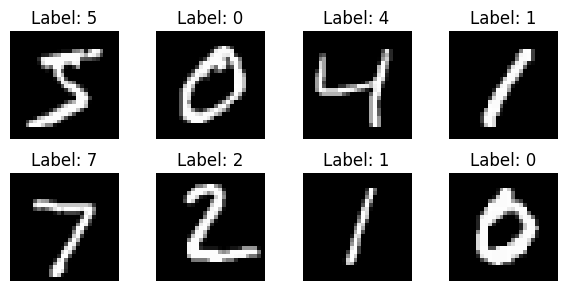

In [ ]:
plt.figure(figsize=(6,3))
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch_train_images[i].squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.title('Label: %d' % batch_train_targets[i].item())
    plt.subplot(2, 4, i+5)
    plt.imshow(batch_test_images[i].squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.title('Label: %d' % batch_test_targets[i].item())
plt.tight_layout()
plt.show()


## Saving and loading a model

When training a model, it is a good practice to make checkpoints every few epochs. That is, store the current state of the model **and the optimizer**. Doing so, we are able to reload the current state of a training process if:
 * the training has been interrupted for an unknown reason (which occurs when using a cluster);
 * we want to diagnose an issue with the model at an early stage (drop of performance, instabilities of the loss, etc.).

It is essential to save the current state of the optimizer, since it contains frequently information acquired during the early stages of training (momentum with SGD + momentum, running means and moments with Adam).

Above all, we define again a model to train and a training process.

**Question 2**

Add lines of code to the function `train_model` to store both the model and the optimizer. One can use `torch.save` and the methods `state_dict` of `Module` and `Optimizer`. Note: one can use `torch.save` to save any PyTorch object **and** any native Python object, such as `dict`.

Add options to `train_model` to resume training from a specific checkpoint.

Launch a training with Adam, stop it, and then resume it.

In [ ]:
def train_model(model, criterion, optimizer, nepochs, save_path = None, load_path = None):
    #List to store loss to vizualise
    train_losses = []
    test_losses = []
    acc_eval = []
    start_epoch = 0

    #save path : où on enregistre le modèle 
    #load path : charger le modèle sans l'enregistrer 

    if load_path is not None : 
        checkpoint = torch. load(load_path, weights_only = False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint["epoch"]+1
        acc_eval = checkpoint["acc_eval"]
        train_losses = checkpoint["train_losses"]
        test_losses = checkpoint["test_losses"]

    for epoch in range(start_epoch, nepochs):
        train_loss =0.
        test_loss = 0.

        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            batch_train_targets+=target
            batch_train_images+=data

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            train_loss+=loss.item()
            optimizer.step()
        ######################
        # validate the model #
        ######################
        model.eval()
        correct = 0
        for data, target in test_loader:
            batch_test_images +=data
            batch_test_targets +=target
            outputs = model(data)
            loss = criterion(outputs, target)

            valid_loss +=loss

            _,pred = torch.max(outputs, 1)
            correct += (pred == target).sum().item()
        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        acc_eval.append(correct/len(test_loader.dataset)*100)
        train_losses.append(train_loss)
        test_losses.append(valid_loss)

        if save_path is not None : 
            torch.save({
                "model state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer. state_dict(),
                "epoch": epoch,
                "acc_eval": acc_eval,
                "train losses": train_losses,
                "test_losses": test_losses
            }, save_path)

        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

## Data normalization

**Question 3**

To make sure that the inputs of the neural network are within a controlled range, we usually transform the dataset to be sure that the data are centered with variance 1. It is not always necessary, but it is worth knowing it.

Check the range of values on a sample of MNIST. Compute the mean and the standard deviation of the training dataset of MNIST and normalize the dataset accordingly by using `transforms.Normalize`.

**ATTENTION**

Normalisation par pixel : certains pixels auront un ecart-type de 0, c'est la cas pour MNIST, les pixels des bords de l'image, donc il est impossible de normaliser. Normalization :\
$x = (x - \mu)\div sigma$

In [28]:
#la moyenne de tous les pixels --> pour chaque canaux de l'image, pour des images en couleurs il ya RGB donc il y a trois canaux ici il n'y en a qu"un
mean = 0.0
std = 0.0
nb_samples = 0

for images, _ in train_loader:
    batch_samples = images.size(0)  
    images = images.view(batch_samples, -1)

    mean += images.mean(1).sum()
    std += images.std(1).sum()
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(mean.item(), std.item())

torchvision.transforms.Normalize(mean, std, inplace=False)

0.13066041469573975 0.30150410532951355


Normalize(mean=0.13066041469573975, std=0.30150410532951355)

In [29]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)
    ])

train_data = datasets.MNIST(datasets_path, train = True, download = True, transform = transform)
test_data = datasets.MNIST(datasets_path, train = False, download = True, transform = transform)

train_size = len(train_data)
test_size = len(test_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

classes = {f"(1)" for i in range(10)}

La noramlisation est intéressante quand nos données sont dans un intervalle trop élevé, ex : pixels entre 0 et 1 ou entre 0 et 265.

## Data augmentation

**Question 4**

It is very common to face overfitting when doing deep learning. So, several methods can be used to solve this problem. One of them is called "data augmentation". It consists in adding "noise" to data points of the training dataset in order to make the model resistant to small changes of the data.

When training on images, it is common to perform "random crops", "random flips", and small "random rotations". With MNIST, it is meaningless to add random flips, because most digits are not supposed to be invariant by vertical or horizontal symmetries.

Add random crops with `transforms.RandomCrop` with a reasonable number of pixels to the transforms to do on the dataset, visualize the resulting images and train the model.

In [ ]:
batch_size = 64
transform = transforms.Compose([
    transforms.RandomCrop(28, padding = 3),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)
    ])

train_data = datasets.MNIST(datasets_path, train = True, download = True, transform = transform)
test_data = datasets.MNIST(datasets_path, train = False, download = True, transform = transform)

train_size = len(train_data)
test_size = len(test_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

classes = {f"(1)" for i in range(10)}
    
#arg dans RandomCrop: padding = nb aléatoire de pixels qui vont être supprimés sur les bords

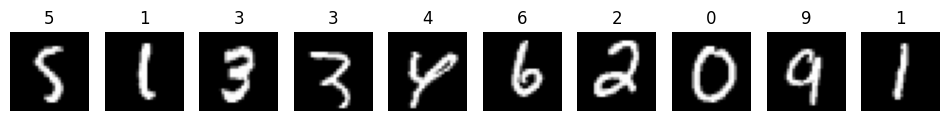

In [35]:
indices = np.random.choice(len(train_data), 10, replace=False)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))

for ax, idx in zip(axes, indices):
    img, label = train_data[idx]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(label)
    ax.axis("off")

plt.show()

## Influence of the initialization

**Question 5**

Build a Multilayer Perceptron with ReLU activation functions, which takes 3 arguments:
 * `layers`: the list of layer sizes;
 * `sigma_w`: the standard deviation chosen for initializing the weights;
 * `with_scaling`: if True, we multiply the generated weights by $1/\sqrt{\# \text{inputs}}$.

Write the `reset_parameters` method, which initialize the weights according to a Gaussian distribution, either with variance $\sigma_w^2$, or $\sigma_w^2/\# \text{inputs}$.

In [ ]:
class Perceptron(torch.nn.Module):
    def __init__(self, layers, sigma_w, scaling = False):
        super(Perceptron, self).__init__()

        

        

        self.reset_parameters()

    def reset_parameters(self):
        pass
        # ...

    def forward(self, x):
        pass
        # ...

**Question 6**

Train the model with various choices of initialization (which ones?) and try various numbers of layers with various widths.

**Question 5 (optional)**

Implement the NTK parameterization in the `Perceptron` model: divide by $1/\sqrt{\# \text{inputs}}$ the result of each layer.

Train such a network with the SGD (with `scaling = False`) with learning rates of order $1$.

# Adam

**Question 7**

Train LeNet with the SGD and Adam with default parameters and compare.

## Other stuff

**Additional questions**

 * explore data augmentation with the dataset CIFAR-10
 * test different batch sizes. How to change the learning rate when we change the batch size?
 * test drop-out layers
 * read the documentation on SGD and Adam an propose a way to assign different learning rates to different sets of parameters